# Supervised learning model: predicting wine quality

This notebook is based on the EliteDataScience tutorial on applied machine learning, aimed at training a random forest for predicting red wine quality. 
We will use the Scikit-Learn library to build the model.

Link to the tutorial: https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn?_ga=2.132886153.648388859.1567025372-80583276.1567025372 

## Setting up the environment

Let us first import the libraries Numpy and Pandas, as well as the functions and modules we will need from scikit-learn:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# utlities to help choosing between models
from sklearn.model_selection import train_test_split

# preprocessing module
from sklearn import preprocessing

# random forest model family
from sklearn.ensemble import RandomForestRegressor

# for cross-validation
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# metrics to evaluate the model performance
from sklearn.metrics import mean_squared_error, r2_score

# save a model for future use (can store efficiently large numpy arrays)
# we use the joblib module insted of the now deprectaed sklearn.joblib
import joblib

## Loading the data

Load the data in `winequality-red.csv`, giving the wine quality as evaluated by experts and 11 parameters:

In [2]:
dataset_file = '../Data/winequality-red.csv'
data = pd.read_csv(dataset_file, sep=';')

Print information on the dataset to make sure no value is missing, as well as the first 5 lines:

In [3]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Print some summary statistics to get a better feel of each column:

In [4]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


We now show the correlation map to see if there are obvious correlations between variables, using the seaborn library:

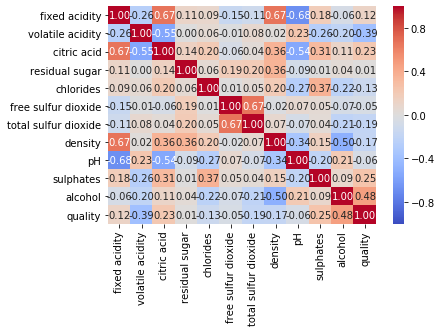

In [5]:
sns.heatmap(data.corr(), annot=True, fmt=".2f", vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

There are significant positive correlations (correlation coefficient larger than or equal to 0.5) between 
* the `citric acid` and `fixed acidity` columns, 
* the `density` and `fixed acidity` columns,
* the `free sulfur dioxide` and `total sulfur dioxide` columns.

The first and third points are intuitive: adding citric acid is expected to increase the acidity, and adding free sulfur dioxide increases (assuming it does not catalyse chemicl reactions destroying non-free dioxide) the total amount of sulfur dioxide. 
Explaining the second point would require more knowledge of the chemistry of wine than I have. 

There is also a moderate (close to 0.5) positive correlation between the `alcohol` and `quality` columns, suggesting that a high alcohol fraction is an important element in wine quality. 

There are significant negative correlations between
* the `fixed acidity` and `pH` columns,
* the `citric acid` and `pH` columns, 
* the `density` and `alcohol` columns. 
The first point is a direct consequence of the definition of the pH, which decreases with acidity. 
The second point was expected: adding citric acid should increase acidity, and thus lower the pH.

There is also a moderate negative correlation between the `quality` and `volatile acidity` columns, suggesting that volatile acidity tends to lower the wine quality.

## Splitting and normalizing data

Let us first split the data into target (y) and training (X) features:

In [6]:
y = data.quality
X = data.drop('quality', axis=1)

We then randomly split the data into training (80%) and test (20%) data:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2,
                                                   random_state=123, # fixed seed to get reproducible results
                                                   stratify=y)

After that, we normalize the data using a scaler save for later re-use:

In [8]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

We check that the mean of the result is zero within rounding errors and its standard deviation is 1:

In [9]:
print(X_train_scaled.mean(axis=0))
print(X_train_scaled.std(axis=0))

[ 1.16664562e-16 -3.05550043e-17 -8.47206937e-17 -2.22218213e-17
  2.22218213e-17 -6.38877362e-17 -4.16659149e-18 -2.54439854e-15
 -8.70817622e-16 -4.08325966e-16 -1.17220107e-15]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


We then rescale the test data using the same scaler:

In [10]:
X_test_scaled = scaler.transform(X_test)
print(X_test_scaled.mean(axis=0))
print(X_test_scaled.std(axis=0))

[ 0.02776704  0.02592492 -0.03078587 -0.03137977 -0.00471876 -0.04413827
 -0.02414174 -0.00293273 -0.00467444 -0.10894663  0.01043391]
[1.02160495 1.00135689 0.97456598 0.91099054 0.86716698 0.94193125
 1.03673213 1.03145119 0.95734849 0.83829505 1.0286218 ]


## Declaring the hyperparameters and tuning them on the training data

Define the pipeline:

In [11]:
pipeline = make_pipeline(preprocessing.StandardScaler(), # scaler
                        RandomForestRegressor(n_estimators=100)) # random forest

Look at the available parameters:

In [12]:
pipeline.get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('randomforestregressor',
   RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                         max_features='auto', max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=100,
                         n_jobs=None, oob_score=False, random_state=None,
                         verbose=0, warm_start=False))],
 'verbose': False,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'randomforestregressor': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1,

Declare the hyperparameters we want to tune:

In [13]:
hyperparameters = {'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}

Tune the hyperparameters through cross-validation with 10 folds:

In [14]:
clf = GridSearchCV(pipeline, hyperparameters, cv=10)
clf.fit(X_train, y_train)
print(clf.best_params_)

{'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 'auto'}


Check that the model is refit using the entire training set:

In [15]:
clf.refit

True

## Prediction and validation

Predict the test target from the test input and compute the coefficient of determination and mean squared error:

In [16]:
y_pred = clf.predict(X_test)
print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

0.4579361946849084
0.349779375


The r² coefficient is larger than 0.4. 
We deduce that the model can give an idea of the wine quality.

## Save the model for future use

Saving the model:

In [17]:
joblib.dump(clf, '../Models/rf_regressor_wine.pkl')

['../Models/rf_regressor_wine.pkl']

Loading the model:

In [18]:
clf2 = joblib.load('../Models/rf_regressor_wine.pkl')
print(clf2.predict(X_test))

[6.55 5.83 5.   5.62 6.35 5.75 4.95 4.68 5.01 6.02 5.34 5.76 5.84 5.04
 5.81 5.63 6.74 5.81 5.81 6.98 5.51 5.65 5.04 5.95 5.95 5.11 5.67 5.13
 5.97 5.97 5.85 6.49 6.   4.95 4.93 5.93 5.01 5.87 5.05 5.76 4.89 5.87
 6.8  5.11 6.15 5.41 5.62 5.56 5.07 6.44 5.93 5.29 5.86 5.15 5.58 5.63
 5.26 5.34 4.95 5.24 5.43 5.06 5.   5.86 5.9  5.28 6.44 5.05 5.11 6.65
 5.75 5.5  5.06 5.01 5.43 6.02 5.45 5.11 5.29 5.22 6.71 5.59 6.24 6.64
 5.08 5.91 6.56 6.16 5.64 5.82 5.94 5.33 6.49 5.65 5.62 5.81 6.6  6.83
 5.56 6.73 5.09 5.48 5.15 6.66 5.   4.59 5.75 5.   5.64 6.08 5.69 5.55
 6.07 5.48 5.03 5.24 5.91 5.05 5.04 6.   5.83 5.06 5.76 5.97 5.22 5.34
 5.15 5.88 5.48 5.43 5.82 6.3  5.1  5.21 5.08 6.54 5.02 5.1  6.68 5.45
 5.17 5.1  5.91 6.1  5.42 5.49 5.05 6.49 5.51 5.04 5.5  5.1  4.89 4.95
 5.19 5.92 5.39 5.83 5.78 5.39 5.65 5.15 5.27 5.93 5.03 5.94 5.19 5.17
 5.56 5.18 5.7  4.98 5.69 5.07 5.74 5.36 5.04 5.32 5.52 5.08 6.02 5.59
 5.07 4.97 5.25 6.15 5.12 5.52 5.33 4.79 5.43 6.58 5.81 6.04 5.45 5.15
 5.41 

Graphical representation of the difference between the model prediction and actual wine quality

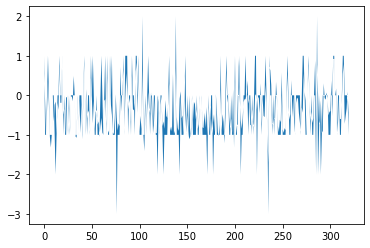

In [19]:
plt.fill_between(range(len(y_test)), clf2.predict(X_test)-6, np.array(y_test)-6)
plt.show()

## Comparison with a neural network

Let us compare these results with those obtained from a different model. 
We use a simple neural network, using the `NeuralNetwork1` class from the module `NN1`, written in C++ using Boost.Python. 
It uses a sigmoid as activation function and mean square error as loss function.

In [20]:
# import the NN1 module
import sys
sys.path.append('../C++')
import NN1

This module works with lists instead of data frames. 
We thus convert the traininfg and test data to lists. 
We divide the wine ratings by 10 to get values between 0 and 1.

In [21]:
X_train_nn = [X_train.iloc[i].tolist() for i in range(X_train.shape[0])]
y_train_nn = (y_train/10).tolist()

X_test_nn = [X_test.iloc[i].tolist() for i in range(X_test.shape[0])]
y_test_nn = (y_test/10).tolist()

We then define a simple neural network with a single hidden layer with 11 neurons and train it.

In [31]:
nn = NN1.NeuralNetwork1([11,1]) # neural network with one hidden layer of 11 neurons and an ouput layer of 1 neuron
print(nn.loss(X_train_nn, y_train_nn)) # loss function before training
nn.train(X_train_nn, y_train_nn, 0.1, 1000) # training with a learning rate of 0.1 and 1000 epochs
print(nn.loss(X_train_nn, y_train_nn)) # loss function after training

0.02665733429095925
0.004322101451397532


Finally, we define the function `predict_quality_nn` returning the neural network prediction for the wine quality, and compute the r² score and mean square error.

In [32]:
def predict_quality_nn(x):
    return 10*nn.feedforward(x)[0]

y_pred_nn = [predict_quality_nn(x) for x in X_test_nn]
print(r2_score(y_test, y_pred_nn))
print(mean_squared_error(y_test, y_pred_nn))

0.2705411934378321
0.47070039162501776


The r² score is somewhat smaller, and the mean squared error larger, than those obtained with the previous model. 

## Conclusion

We have built a Random Forest model for predicting wine quality from 11 parameters using the `winequality-red.csv` dataset. 
This model is able to give a first idea of the result, although not a very accurate one. 
We also showed that it compares favourably with a (very simple) neural network model.
Two possibilities to improve it would be: 
* working with a larger dataset (we have less than 1600 entries, which is small for a model with 11 parameters), 
* separating wines into different categories, using for instance its age.